In [1]:
import time
import numpy as np
import pandas as pd
import json
import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.interpolate import griddata

np.random.seed(42)

We define first several plotting utilities to better visualize agents spatial organization and heatmaps.

In [2]:
def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

def plot_2d_hypercube(ax, hypercube, color="C0", alpha=0.4, label=None):
    barycenter = hypercube.center()
    side_lengths = hypercube.side_lengths()
    anchor = barycenter - side_lengths / 2
    square = Rectangle(anchor, side_lengths[0], side_lengths[1], edgecolor=color, facecolor=color, alpha=alpha, label=label)
    
    # ax.plot(barycenter[0], barycenter[1], "o", color=color)
    ax.add_patch(square)
    return square

def plot_3d_agent(ax, agent, n_points=3, alpha=0.2, color="C0"):
    if agent.is_mature():
        l, h = agent.validity.low[:2], agent.validity.high[:2]
        X = np.linspace(l[0], h[0], n_points)
        Y = np.linspace(l[1], h[1], n_points)
        X, Y = np.meshgrid(X, Y)
        features = np.vstack([X.flatten(), Y.flatten()]).T
        y = agent.predict(features)
        ax.plot_trisurf(features[:, 0], features[:, 1], y.ravel(), alpha=alpha, color=color, cmap="viridis")

## 1. Data Generation

In [3]:
# 2D functions used to compute targets
def sin_sqrt(X):
    return np.sin(np.sqrt(X[:, 0]**2 + X[:, 1]**2))

def booth(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((X1 + 2*X2 - 7)**2 + (2*X1 + X2 - 5)**2)

def goldstein_price(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((1+(X1 + X2 + 1)**2*(19-14*X1+3*X1**2-14*X2+6*X1*X2+3*X2**2))*(30+(2*X1-3*X2)**2*(18-32*X1+12*X1**2+48*X2-36*X1*X2+27*X2**2)))

def beale(X):
    X1, X2 = X[:, 0], X[:, 1]
    return (1.5 - X1 + X1*X2)**2 + (2.25 - X1 + X1*X2**2)**2 + (2.625 - X1 + X1*X2**3)**2

# function to generate 2D input data
def generate_X(n_samples, ranges=[(0, 1), (0, 1)], random_state=None):
    dim = len(ranges)
    assert dim > 0
    rng = np.random.default_rng(random_state)
    X = np.zeros((n_samples, dim))
    for i, r in enumerate(ranges):
        low, high = r
        X[:, i] = rng.uniform(low, high, n_samples)
    return X

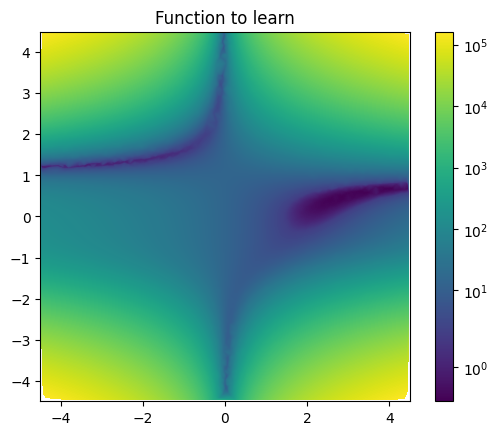

In [4]:
seed = 42
n_samples = 10000
fn = beale
features = generate_X(n_samples, ranges=[(-4.5, 4.5), (-4.5, 4.5)], random_state=seed)
targets = fn(features)

X_train, X_test, y_train, y_test = train_test_split(features, targets , test_size=0.2)

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(ax, features[:, 0], features[:, 1], targets, norm="symlog")
ax.set_title("Function to learn")
fig.colorbar(pcm)

## 2. Preprocessing

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
scaler.fit(X_train)

MinMaxScaler(feature_range=(-1, 1))

## 3. Training

We instantiate `FastHeadAgent` which is an implementation of our MAS that use rtrees to select agents. Then we train the model using the `fit` method.

In [6]:
from mas import head

model = head.FastHeadAgent(
    R=np.full(2, 0.1),
    alpha=0.2,
    bad_th=0.3,
    imprecise_th=0.1,
    memory_length=20,
    min_vol=0.
)

model.fit(scaler.transform(X_train), y_train, epochs=5, verbose=True)

[agents: 1284 | maturity: 0.00% | vol+: 0.0766 | vol-: -4.3869]: 100%|██████████| 8000/8000 [00:12<00:00, 656.94it/s]
[agents: 1995 | maturity: 39.15% | vol+: 0.0710 | vol-: -2.0581]: 100%|██████████| 8000/8000 [00:12<00:00, 626.64it/s]
[agents: 2442 | maturity: 50.66% | vol+: 0.0542 | vol-: -0.9327]: 100%|██████████| 8000/8000 [00:13<00:00, 592.41it/s]
[agents: 2730 | maturity: 60.48% | vol+: 0.0286 | vol-: -0.4899]: 100%|██████████| 8000/8000 [00:13<00:00, 586.99it/s]
[agents: 2903 | maturity: 68.10% | vol+: 0.0193 | vol-: -0.2819]: 100%|██████████| 8000/8000 [00:13<00:00, 575.73it/s]


## 4. Visualization

We visualize the prediction of our model on the test set.

Text(0.5, 1.0, 'Predictions on test set')

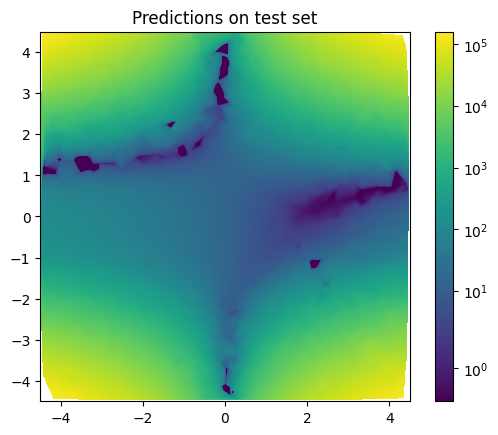

In [7]:
from mas.hypercube import *

y_pred = model.predict(scaler.transform(X_test))

ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test, norm="symlog", interpolation="linear")
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_pred, norm="symlog", interpolation="linear")
pcm.set_clim(min(y_test), max(y_test))
plt.colorbar(pcm)
plt.title("Predictions on test set")

We can visualize in two dimensions the spatial organization of context agents. Each blue rectangle in the plot corresponds to a single agent.

Text(0, 0.5, 'Y')

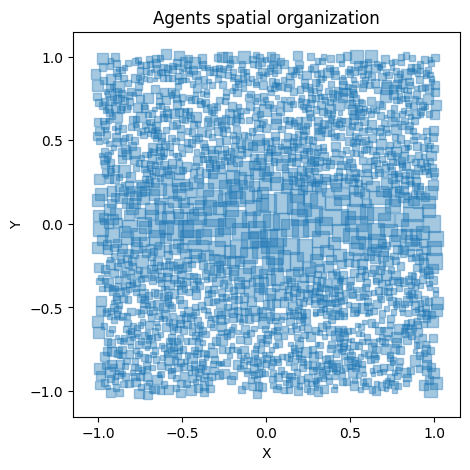

In [8]:
plt.figure(figsize=(5, 5))

ax = plt.gca()
ax.scatter(scaler.transform(X_train)[:, 0], scaler.transform(X_train)[:, 1], marker="o", c="r", alpha=0)

for a in model.context_agents.values():
    plot_2d_hypercube(ax, a.validity)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

We can also visualize the *Context* agents mapping between the **input** and **output** space.

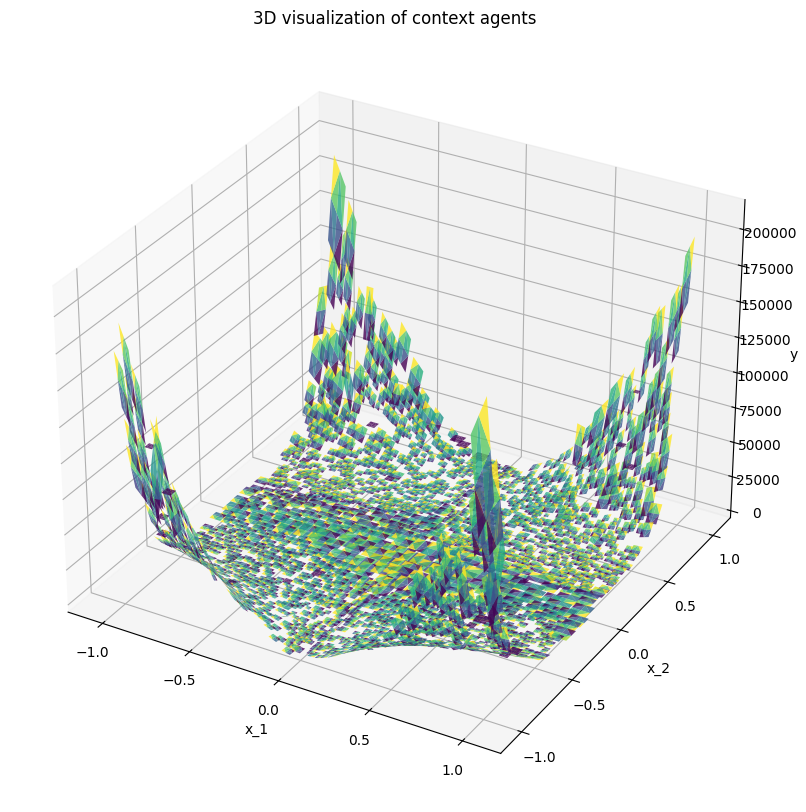

In [9]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 10))
axs.set_xlabel("x_1")
axs.set_ylabel("x_2")
axs.set_zlabel("y")
axs.set_title("3D visualization of context agents")

for a in model.context_agents.values():
    c = "C0"
    plot_3d_agent(axs, a, alpha=0.8)

#### Degree of discrepancy

the degree of discrepancy $\kappa$ among the predictions of all *Context* agents in the neighborhood ($\mathcal{D}_{\text{proposals}}$) is defined as:

$$\kappa=\frac{\sqrt{\sum_{p\in\mathcal{D}_{\text{proposals}}}\frac{\left|p-p_{\text{mean}}\right|}{N_{\text{agents}}}}}{\left|y_{\text{mean}}\right|}$$

where $N_{\text{agents}}$ is the number of *Context* agents in the neighborhood, and $y_{\text{mean}}$ is the average of proposals from the *Context* agents in the neighborhood.

If $\kappa$ is close to $0$, then the predictions of the *Context* agents in the neighborhood are very close to each other. This indicates that the underlying function of the data varies little around the observation. Conversely, if its value is high, then the *Context* agents in the neighborhood make very different predictions, suggesting that the regime of variation of the underlying function is likely to change abruptly in that area. The degree of discrepancy helps identify regions in the input space where approximating the underlying function is most challenging.

100%|██████████| 2000/2000 [00:03<00:00, 643.76it/s]


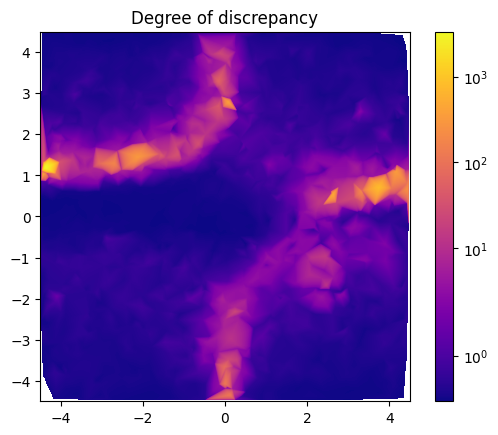

In [10]:
def discrepancy(obs, neighborhood_agents):
    preds = [a.predict(obs) for a in neighborhood_agents]
    return np.std(preds), np.mean(preds)


pbar = tqdm.tqdm(scaler.transform(X_test))

discrepancies = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [model.context_agents[i] for i in model.agent_index.intersection(neighborhood.bounding_box)]
    std, mean = discrepancy(x, neighborhood_agents)
    discrepancies.append(std) 

discrepancies = np.array(discrepancies)
degree_of_discrepancy = discrepancies / np.abs(y_pred)

ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], degree_of_discrepancy, n_points=1000, cmap="plasma", norm="symlog")
plt.title("Degree of discrepancy")
plt.colorbar(pcm)
plt.show()

#### Density

The density of *Context* agents around an observation is defined as:
$$\rho=\frac{N_{\text{agents}}}{V_{\text{neighborhood}}}$$

The shape of a *Context* agent depends on the region of space it occupies. Moreover, within the validity area delimited by its associated hyperrectangle, the function underlying the data is locally approximable by a simple model. Therefore, in a region containing a large number of *Context* agents, variations in the underlying function are likely to be more difficult to learn.

100%|██████████| 2000/2000 [00:00<00:00, 16695.08it/s]


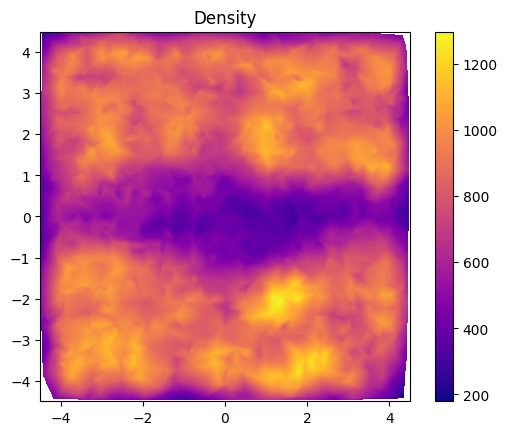

In [11]:
pbar = tqdm.tqdm(scaler.transform(X_test))

densities = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [model.context_agents[i] for i in model.agent_index.intersection(neighborhood.bounding_box)]
    n_neighbors = len(neighborhood_agents)
    density = n_neighbors / neighborhood.volume()
    densities.append(density)

densities = np.array(densities)
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], densities, n_points=1000, cmap="plasma")
plt.title("Density")
plt.colorbar(pcm)
plt.show()

#### Mean Volume

100%|██████████| 2000/2000 [00:00<00:00, 4766.28it/s]


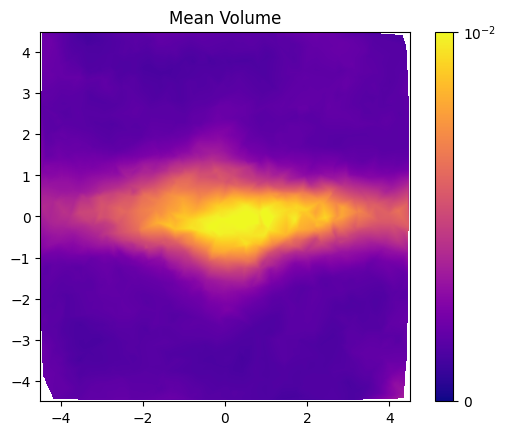

In [12]:
pbar = tqdm.tqdm(scaler.transform(X_test))

mean_vols = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents_volume = [model.context_agents[i].validity.volume() for i in model.agent_index.intersection(neighborhood.bounding_box)]
    v = np.mean(neighborhood_agents_volume)
    mean_vols.append(v)

mean_vols = np.array(mean_vols)
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], mean_vols, n_points=1000, cmap="plasma", norm="symlog")
pcm.set_clim(np.round(min(mean_vols), decimals=2), np.round(max(mean_vols), decimals=2))
plt.title("Mean Volume")
plt.colorbar(pcm)
plt.show()

#### Usefulness of coverage index

During training, the *Context* agents organize themselves in the input space. Depending on the training dataset and the complexity of the underlying function, the result of self-organization varies. Gaps (uncovered zones) in the agent tiling may remain. It is possible that for a given observation, no *Context* agent is activated. 

In such cases, making a prediction requires relying on the proposals of the nearest agents in the observation's neighborhood. To determine if the agents' prediction is reliable, we define the coverage index $p_{\text{coverage}}$ of the observation's neighborhood as:

$$p_{\text{coverage}}=\frac{V_{\text{agents}}}{V_{\text{neighborhood}}}$$

where $V_{\text{agents}}$ is the volume covered by the *Context* agents in the neighborhood and $V_{\text{neighborhood}}$ is the volume of the hyperrectangle representing the neighborhood.

Thus, if $p_{\text{coverage}}$ is close to 1, then the space around the observation contains few gaps: our model is proficient in that region of space. Therefore, it is relevant to consider the predictions of nearby agents. Conversely, if $p_{\text{coverage}}$ is close to $0$, then the space around the observation contains many gaps. There is a high probability that this region of space was underexplored during training. 

This may indicate either gaps in the training data specific to that area of space, or that training did not proceed as expected for various reasons (strong non-linearities in the function to approximate, presence of noise, discontinuity, etc...). We illustrate the utility of the coverage index in a scenario where our system learns from a dataset with an entire portion of missing data.

First, we generate a synthetic dataset and remove a patch of data from it.

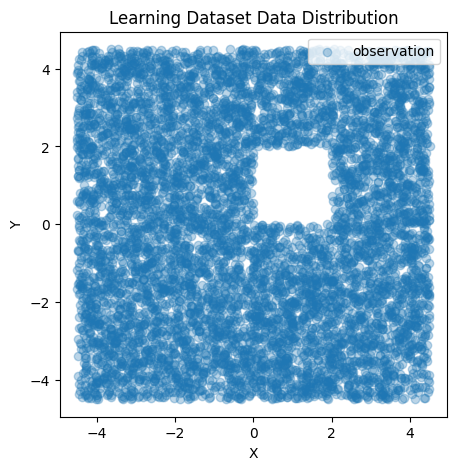

In [13]:
fig = plt.figure(figsize=(5, 5))
x_l, x_h = 0, 2
y_l, y_h = 0, 2

x = X_train[:, 0]
y = X_train[:, 1]
x_mask = (x > x_l) & (x < x_h)
y_mask = (y > y_l) & (y < y_h)
X_train_crop = X_train[~(x_mask & y_mask)]
y_train_crop = y_train[~(x_mask & y_mask)]


plt.scatter(X_train_crop[:, 0], X_train_crop[:, 1], alpha=0.3, label="observation")
plt.title("Learning Dataset Data Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper right")

We train our model on the cropped dataset.

In [14]:
r_coeff = 0.1
crop_model = head.FastHeadAgent(
    R=np.full(2, r_coeff),
    imprecise_th=0.01,
    bad_th=0.5,
    alpha=0.2,
    min_vol=0.,
    memory_length=200,
)

crop_model.fit(scaler.transform(X_train_crop), y_train_crop, epochs=5, verbose=True)


[agents: 1223 | maturity: 0.00% | vol+: 0.1031 | vol-: -4.0717]: 100%|██████████| 7572/7572 [00:11<00:00, 643.32it/s]
[agents: 1863 | maturity: 40.26% | vol+: 0.0959 | vol-: -2.0176]: 100%|██████████| 7572/7572 [00:13<00:00, 574.05it/s]
[agents: 2301 | maturity: 50.54% | vol+: 0.0551 | vol-: -0.9032]: 100%|██████████| 7572/7572 [00:15<00:00, 492.11it/s]
[agents: 2552 | maturity: 60.11% | vol+: 0.0396 | vol-: -0.4838]: 100%|██████████| 7572/7572 [00:14<00:00, 519.47it/s]
[agents: 2738 | maturity: 69.39% | vol+: 0.0323 | vol-: -0.2672]: 100%|██████████| 7572/7572 [00:14<00:00, 511.76it/s]


Then, when visualizing the spatial organization of agents we notice that the area where we have remove data is not covered by *Context* agents.

Text(0, 0.5, 'Y')

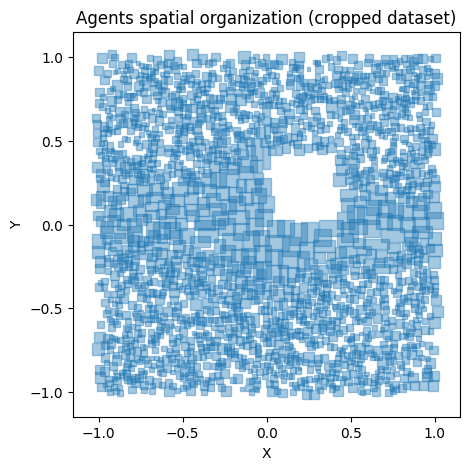

In [15]:
plt.figure(figsize=(5, 5))

ax = plt.gca()
ax.scatter(scaler.transform(X_train)[:, 0], scaler.transform(X_train)[:, 1], marker="o", c="r", alpha=0)

for a in crop_model.context_agents.values():
    plot_2d_hypercube(ax, a.validity)
ax.set_title("Agents spatial organization (cropped dataset)")
ax.set_xlabel("X")
ax.set_ylabel("Y")

The coverage index helps identify the missing portion of data in the training dataset without having directly access to the actual training dataset.

In [16]:
def coverage_index(neighborhood, neighborhood_agents, n_samples=100):
    hypercubes = [overlap(a.validity, neighborhood) for a in neighborhood_agents]
    if len(hypercubes) == 0:
        return 0
    x_, y_ = np.meshgrid(*[np.linspace(l, h, int(np.sqrt(n_samples))) for l, h in zip(neighborhood.low, neighborhood.high)])
    x_, y_ = x_.flatten(), y_.flatten()
    samples = np.stack([x_, y_]).T
    nb_overlapped = 0
    for s in samples:
        overlapped = False
        for h in hypercubes:
            overlapped = h.contains(s).all()
            if overlapped:
                nb_overlapped += 1
                break
    return (nb_overlapped * neighborhood.volume() / n_samples)/ neighborhood.volume()

pbar = tqdm.tqdm(scaler.transform(X_test))

coverage_indexs = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [crop_model.context_agents[i] for i in crop_model.agent_index.intersection(neighborhood.bounding_box)]
    cov_index = coverage_index(neighborhood, neighborhood_agents)
    coverage_indexs.append(cov_index)

coverage_indexs = np.array(coverage_indexs)

100%|██████████| 2000/2000 [00:10<00:00, 183.65it/s]


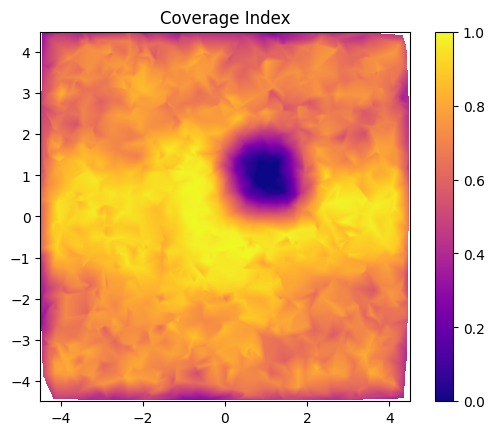

In [17]:
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], coverage_indexs, n_points=1000, cmap="plasma")
pcm.set_clim(np.round(min(coverage_indexs), decimals=2), np.round(max(coverage_indexs), decimals=2))
plt.title("Coverage Index")
plt.colorbar(pcm)
plt.show()